In [1]:
import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from torch.utils.data import DataLoader, Dataset

from pydub import AudioSegment
import soundfile as sf

import matplotlib.pyplot as plt
import librosa.display

In [2]:
class MelDataset(Dataset):
    def __init__(self, wav_dir, sr=44100, n_mels=128, duration=5.0, hop_length=256, preload=True):
        self.files = [os.path.join(wav_dir, f) for f in os.listdir(wav_dir) if f.endswith('.wav')]
        self.sr = sr
        self.n_mels = n_mels
        self.duration = duration
        self.hop_length = hop_length
        self.n_samples = int(sr * duration)
        self.preload = preload

        if self.preload:
            print(f"🔁 Preloading {len(self.files)} audio files into memory...")
            self.cache = [self.process_file(f) for f in self.files]
        else:
            self.cache = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return self.cache[idx] if self.preload else self.process_file(self.files[idx])

    def process_file(self, path):
        y, _ = librosa.load(path, sr=self.sr)
        n_samples = self.n_samples

        if len(y) > n_samples:
            start = np.random.randint(0, len(y) - n_samples)
            y = y[start:start + n_samples]
        else:
            y = np.pad(y, (0, n_samples - len(y)), mode='constant')

        mel = librosa.feature.melspectrogram(y=y, sr=self.sr, n_mels=self.n_mels, hop_length=self.hop_length)
        mel_db = librosa.power_to_db(mel, ref=np.max).T  # [T, n_mels]

        # Optional: enforce fixed T = 864 (~5s)
        T_target = int(np.ceil(self.duration * self.sr / self.hop_length))
        if mel_db.shape[0] < T_target:
            pad_len = T_target - mel_db.shape[0]
            mel_db = np.pad(mel_db, ((0, pad_len), (0, 0)), mode='constant')
        else:
            mel_db = mel_db[:T_target]

        mel_db = (mel_db + 80.0) / 80.0
        mel_db = mel_db * 2.0 - 1.0
        mel_tensor = torch.tensor(mel_db, dtype=torch.float32).unsqueeze(0).transpose(1, 2)  # [1, 128, T]
        return mel_tensor


In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(dropout),  # 🔥 dropout inserted here
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.relu(x + self.block(x))

class DilatedTemporalConv1D(nn.Module):
    def __init__(self, channels, dilation_rates=(1, 2, 4)):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(channels, channels, kernel_size=(1, 3), padding=(0, d), dilation=(1, d))
            for d in dilation_rates
        ])
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        out = x
        for conv in self.layers:
            out = self.act(conv(out)) + out  # residual
        return out


class LightSkipDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res1 = ResidualBlock(256)

        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res2 = ResidualBlock(128)

        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.skip_proj1 = nn.Conv2d(128, 64, kernel_size=1)
        self.conv3 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res3 = ResidualBlock(64)

        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')
        self.skip_proj2 = nn.Conv2d(128, 32, kernel_size=1)
        self.conv4 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout2d(0.2)
        )
        self.res4 = ResidualBlock(32)

        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1)
        )
        self.res5 = ResidualBlock(16)
        self.res6 = ResidualBlock(16)

        self.temporal_dilated = DilatedTemporalConv1D(16)

        self.out_conv = nn.Sequential(
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.Conv2d(1, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.up1(x)
        x = self.conv1(x)
        x = self.res1(x)

        x = self.up2(x)
        x1 = self.conv2(x)
        x = self.res2(x1)

        x = self.up3(x)
        skip1 = F.interpolate(self.skip_proj1(x1), size=x.shape[-2:], mode='nearest')
        x = torch.cat([x, skip1], dim=1)
        x = self.conv3(x)
        x = self.res3(x)

        x = self.up4(x)
        skip2 = F.interpolate(self.skip_proj2(x1), size=x.shape[-2:], mode='nearest')
        x = torch.cat([x, skip2], dim=1)
        x = self.conv4(x)
        x = self.res4(x)

        x = self.up5(x)
        x = self.conv5(x)
        x = self.res5(x)
        x = self.res6(x)
        x = self.temporal_dilated(x)

        x = F.interpolate(x, size=(128, 862), mode='nearest')
        x = self.out_conv(x)
        return x


class VAE(nn.Module):
    def __init__(self, input_dim=(128, 862), latent_dim=512):
        super().__init__()
        c, t = input_dim

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(0.1),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(self.encoder_conv, self.flatten)

        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, c, t)
            features = self.encoder_conv(dummy_input)
            self.decoder_shape = features.shape[1:]
            self.enc_out_dim = features.view(1, -1).size(1)
            print(f"decoder_shape: {self.decoder_shape} → flattened: {self.enc_out_dim}")

        self.fc_mu = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.enc_out_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, self.enc_out_dim)
        self.decode_dropout = nn.Dropout(p=0.3)  # <-- added dropout

        self.decoder = LightSkipDecoder()

        # Weight init
        for m in self.decoder.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

        for m in self.encoder_conv.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decode_dropout(self.fc_decode(z))  # <-- apply dropout here
        h = h.view(z.size(0), *self.decoder_shape)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar



In [4]:
# === Smooth temporal and spectral energy
def smoothing_loss(x, alpha=1.0, beta=0.5):
    dt = torch.abs(x[:, :, 1:, :] - x[:, :, :-1, :]).mean()  # time diff
    df = torch.abs(x[:, :, :, 1:] - x[:, :, :, :-1]).mean()  # freq diff
    return alpha * dt + beta * df

# === Match energy at different temporal resolutions
def multi_scale_loss(x_recon, x):
    loss = 0.0
    for scale in [2, 4, 8]:
        recon_down = F.avg_pool2d(x_recon, kernel_size=(1, scale))
        x_down = F.avg_pool2d(x, kernel_size=(1, scale))
        loss += F.l1_loss(recon_down, x_down)
    return loss

# === Emphasize high-frequency bins
def frequency_weighted_l1(x_recon, x, min_weight=0.5, max_weight=2.0):
    B, C, F, T = x.shape
    weights = torch.linspace(min_weight, max_weight, F, device=x.device).view(1, 1, F, 1)
    return torch.abs((x_recon - x) * weights).mean()

def decode_in_chunks(mu, model, chunk_size=4):
    outputs = []
    for i in range(0, mu.size(0), chunk_size):
        with torch.no_grad():
            chunk = mu[i:i + chunk_size]
            out = model.decode(chunk)
            outputs.append(out)
    return torch.cat(outputs, dim=0)


# === Optional: spectral contrast loss via librosa
def spectral_contrast_loss(x_recon, x, sr=44100, n_fft=1024, hop_length=256,
                           band_weighting=True, use_delta=True, lambda_delta=0.2):
    B = x.shape[0]
    total_loss = 0.0

    for i in range(B):
        S_recon = x_recon[i, 0].detach().cpu().numpy()
        S_true = x[i, 0].detach().cpu().numpy()

        contrast_recon = librosa.feature.spectral_contrast(S=S_recon, sr=sr,
                                                           n_fft=n_fft, hop_length=hop_length)
        contrast_true = librosa.feature.spectral_contrast(S=S_true, sr=sr,
                                                          n_fft=n_fft, hop_length=hop_length)

        # === Main contrast diff
        diff = np.abs(contrast_recon - contrast_true)

        if band_weighting:
            band_weights = np.array([0.8, 1.2, 1.6, 2.0, 2.5, 3.0, 3.0], dtype=np.float32).reshape(-1, 1)
            diff *= band_weights

        loss = diff.mean()

        # === Delta contrast (temporal dynamics)
        if use_delta:
            delta_true = np.diff(contrast_true, axis=1)
            delta_recon = np.diff(contrast_recon, axis=1)
            delta_diff = np.abs(delta_recon - delta_true)

            if band_weighting:
                delta_diff *= band_weights  # ✅ correct shape (7, 1)

            delta_loss = delta_diff.mean()
            loss += lambda_delta * delta_loss

        total_loss += loss

    return torch.tensor(total_loss / B, dtype=torch.float32, requires_grad=True).to(x.device)




# === Final VAE loss
def vae_loss(x_recon, x, mu, logvar, model,
             beta=1.0, free_bits=0.01,
             lambda_smooth=0.1,
             lambda_multiscale=0.1,
             lambda_contrast=0.0):
    # Align time dimension
    min_T = min(x.shape[-1], x_recon.shape[-1])
    x = x[..., :min_T]
    x_recon = x_recon[..., :min_T]

    # === Reconstruction loss
    recon_loss = frequency_weighted_l1(x_recon, x)

    # === KL with free bits
    logvar = torch.clamp(logvar, min=-10, max=10)
    kl = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())
    kl = torch.clamp(kl, min=free_bits)
    kl_loss = kl.sum(dim=1).mean()

    # === Regularization
    smooth_loss = smoothing_loss(x_recon - x)
    ms_loss = multi_scale_loss(x_recon, x)

    # === Spectral contrast loss
    contrast_loss = spectral_contrast_loss(x_recon, x) if lambda_contrast > 0 else torch.tensor(0.0, device=x.device)

    # === Latent variance regularization
    latent_var_reg = torch.mean(torch.exp(logvar))  # encourages var > 0

    # === z vs mu recon divergence (make z matter)
    with torch.no_grad():
        x_recon_mu = decode_in_chunks(mu, model, chunk_size=32)  # Adjust chunk size to fit your GPU

    latent_delta_loss = F.l1_loss(x_recon, x_recon_mu)

    # === Total loss
    total_loss = recon_loss \
        + beta * kl_loss \
        + lambda_smooth * smooth_loss \
        + lambda_multiscale * ms_loss \
        + lambda_contrast * contrast_loss \
        + 0.01 * latent_var_reg \
        + 0.01 * latent_delta_loss

    return total_loss, recon_loss, kl_loss, smooth_loss, ms_loss, contrast_loss




In [5]:
dataset = MelDataset(
    wav_dir="data",
    sr=44100,
    n_mels=128,
    duration=5.0,       # fixed 5-second chunks
    hop_length=256,     # make sure this matches your spec generation
    preload=True
)


train_loader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=64  # or 0 for debugging
    # No collate_fn needed anymore if all are same T
)



🔁 Preloading 1000 audio files into memory...


In [6]:
def plot_contrast_maps(mel_orig_norm, mel_recon_norm, sr=44100, hop_length=256, n_fft=1024, n_mels=128):

    # Step 1: De-normalize from [-1, 1] → dB → power
    mel_orig_db = ((mel_orig_norm + 1) / 2.0) * 80.0 - 80.0
    mel_recon_db = ((mel_recon_norm + 1) / 2.0) * 80.0 - 80.0

    mel_orig_power = librosa.db_to_power(mel_orig_db)
    mel_recon_power = librosa.db_to_power(mel_recon_db)

    # Step 2: Approximate inversion of mel to linear frequency
    mel_basis = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)
    inv_mel = np.linalg.pinv(mel_basis)

    spec_orig = np.dot(inv_mel, mel_orig_power)
    spec_recon = np.dot(inv_mel, mel_recon_power)

    # Step 3: Compute spectral contrast
    contrast_orig = librosa.feature.spectral_contrast(S=spec_orig, sr=sr, n_fft=n_fft, hop_length=hop_length)
    contrast_recon = librosa.feature.spectral_contrast(S=spec_recon, sr=sr, n_fft=n_fft, hop_length=hop_length)

    # Step 4: Plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

    im1 = axs[0].imshow(contrast_orig, origin='lower', aspect='auto', cmap='viridis')
    axs[0].set_title("Original Spectral Contrast")
    fig.colorbar(im1, ax=axs[0])

    im2 = axs[1].imshow(contrast_recon, origin='lower', aspect='auto', cmap='viridis')
    axs[1].set_title("Reconstructed Spectral Contrast")
    fig.colorbar(im2, ax=axs[1])

    plt.tight_layout()
    plt.show()


Input mel shape: 128 x 862
🚀 Using device: cuda
decoder_shape: torch.Size([512, 4, 26]) → flattened: 53248
Epoch 01 | Loss=25.8696 | Recon=0.8302 | KL=19.0818 | z.std=1.0000 | Beta=0.001 | Smooth=0.1595 | MS=1.7134 | Contrast=61.8963
Epoch 02 | Loss=25.1214 | Recon=0.7398 | KL=11.8708 | z.std=1.0001 | Beta=0.001 | Smooth=0.1426 | MS=1.5580 | Contrast=60.3304
Epoch 03 | Loss=24.6851 | Recon=0.6687 | KL=14.5757 | z.std=1.0000 | Beta=0.001 | Smooth=0.1227 | MS=1.4162 | Contrast=59.4719
Epoch 04 | Loss=23.6205 | Recon=0.6344 | KL=15.1395 | z.std=1.0000 | Beta=0.001 | Smooth=0.1096 | MS=1.3358 | Contrast=56.9314
Epoch 05 | Loss=22.6138 | Recon=0.6214 | KL=13.5408 | z.std=1.0000 | Beta=0.001 | Smooth=0.1027 | MS=1.3047 | Contrast=54.4677
Original: (128, 862), Recon: (128, 862)


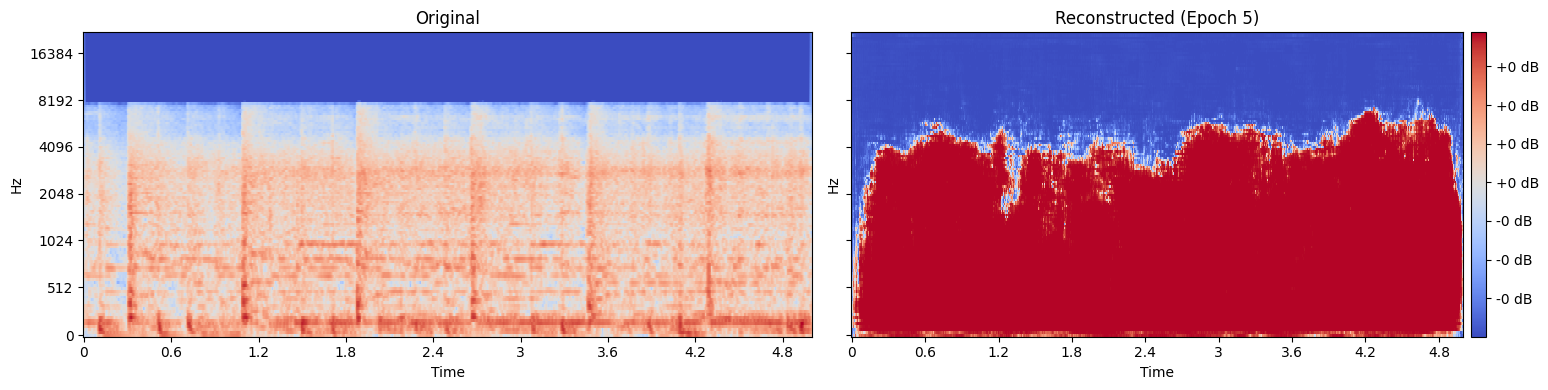

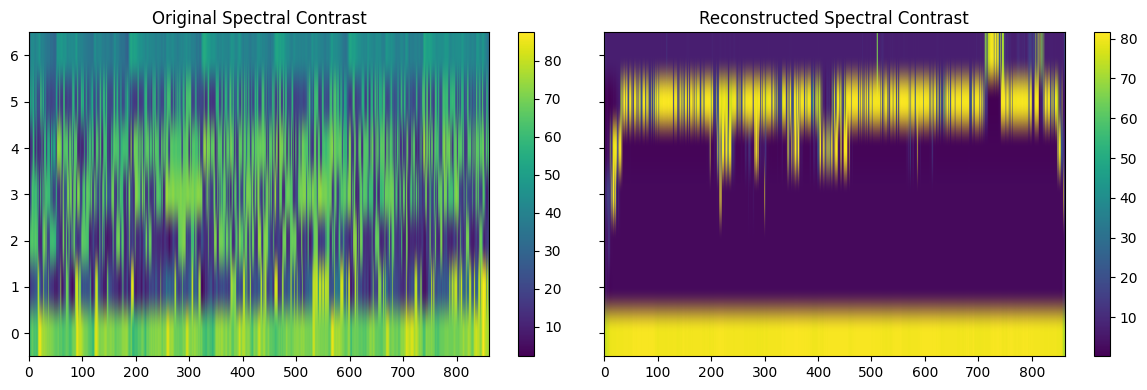

Epoch 06 | Loss=22.2873 | Recon=0.6156 | KL=12.4557 | z.std=1.0000 | Beta=0.001 | Smooth=0.0991 | MS=1.2901 | Contrast=53.6771
Epoch 07 | Loss=22.0313 | Recon=0.6119 | KL=11.6851 | z.std=1.0000 | Beta=0.001 | Smooth=0.0971 | MS=1.2801 | Contrast=53.0534
Epoch 08 | Loss=21.9391 | Recon=0.6085 | KL=11.7095 | z.std=1.0000 | Beta=0.001 | Smooth=0.0957 | MS=1.2718 | Contrast=52.8353
Epoch 09 | Loss=21.8835 | Recon=0.6069 | KL=11.4401 | z.std=1.0000 | Beta=0.001 | Smooth=0.0947 | MS=1.2677 | Contrast=52.7033
Epoch 10 | Loss=21.8109 | Recon=0.6038 | KL=11.1326 | z.std=0.9999 | Beta=0.001 | Smooth=0.0938 | MS=1.2601 | Contrast=52.5336
Original: (128, 862), Recon: (128, 862)


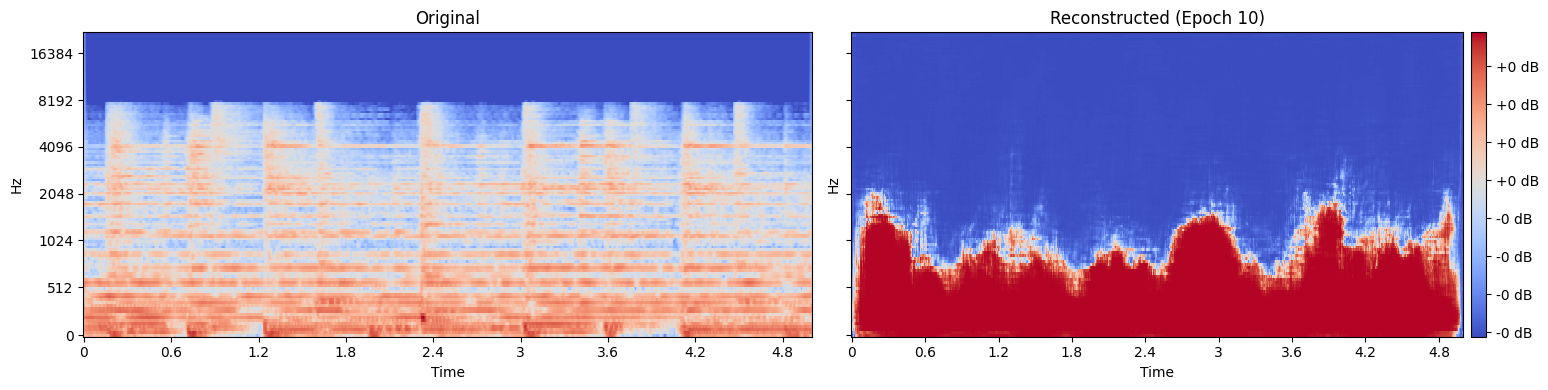

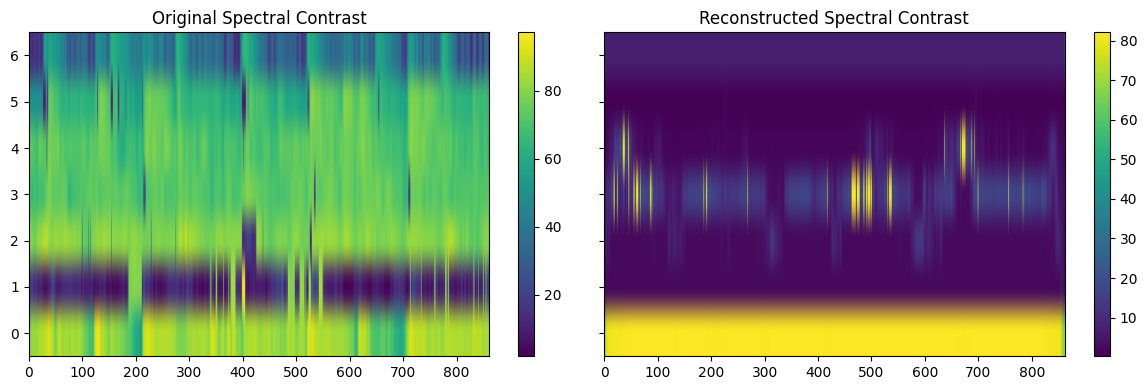

Epoch 11 | Loss=23.8901 | Recon=0.6279 | KL=5.5437 | z.std=1.0000 | Beta=0.050 | Smooth=0.0941 | MS=1.3311 | Contrast=56.9852
Epoch 12 | Loss=23.0778 | Recon=0.6202 | KL=5.1644 | z.std=1.0000 | Beta=0.050 | Smooth=0.0930 | MS=1.3098 | Contrast=55.0288
Epoch 13 | Loss=22.8603 | Recon=0.6172 | KL=5.1661 | z.std=1.0000 | Beta=0.050 | Smooth=0.0928 | MS=1.3009 | Contrast=54.4948
Epoch 14 | Loss=22.7200 | Recon=0.6137 | KL=5.1686 | z.std=1.0000 | Beta=0.050 | Smooth=0.0923 | MS=1.2922 | Contrast=54.1557
Epoch 15 | Loss=22.9075 | Recon=0.6132 | KL=5.1719 | z.std=1.0000 | Beta=0.050 | Smooth=0.0921 | MS=1.2915 | Contrast=54.6256
Original: (128, 862), Recon: (128, 862)


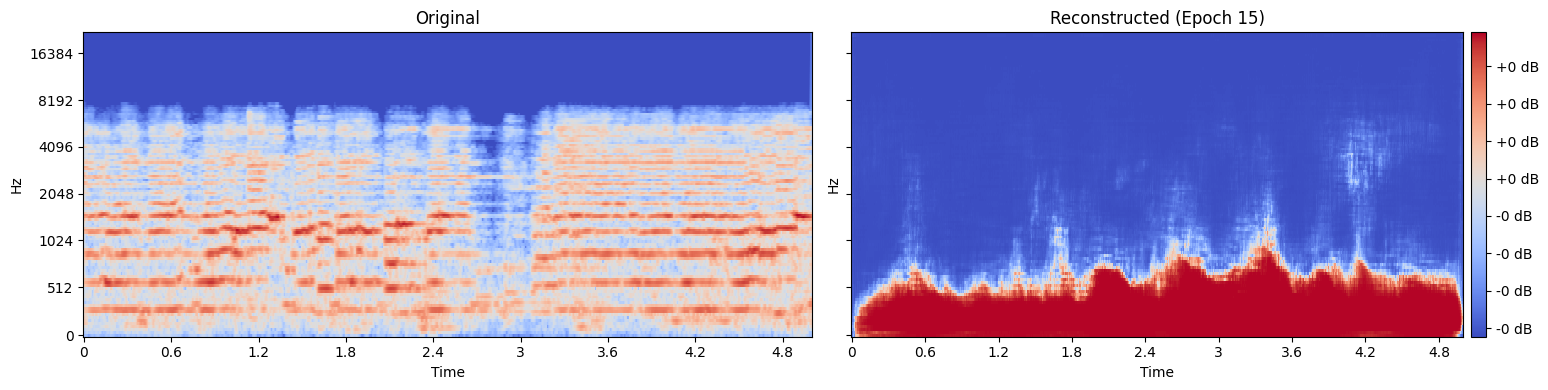

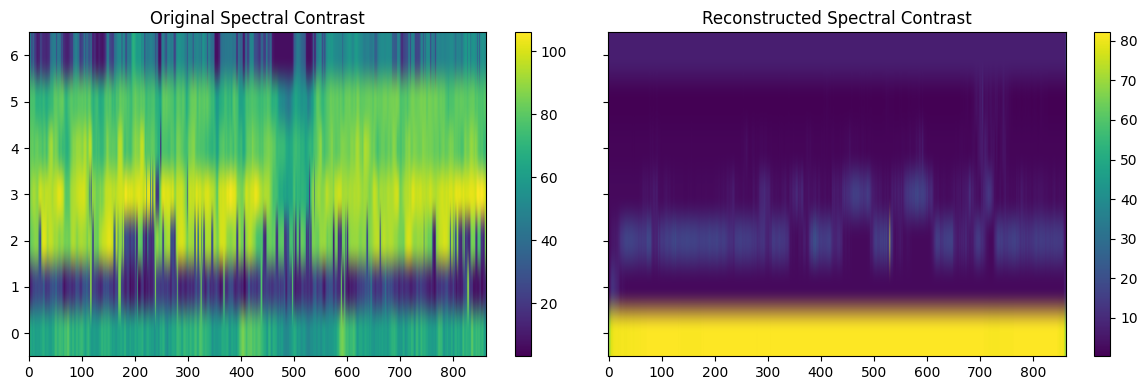

Epoch 16 | Loss=22.7684 | Recon=0.6106 | KL=5.1784 | z.std=1.0000 | Beta=0.050 | Smooth=0.0918 | MS=1.2847 | Contrast=54.2858
Epoch 17 | Loss=22.6636 | Recon=0.6082 | KL=5.1684 | z.std=1.0000 | Beta=0.050 | Smooth=0.0915 | MS=1.2788 | Contrast=54.0330
Epoch 18 | Loss=22.5978 | Recon=0.6072 | KL=5.1711 | z.std=1.0000 | Beta=0.050 | Smooth=0.0912 | MS=1.2766 | Contrast=53.8716
Epoch 19 | Loss=22.7504 | Recon=0.6053 | KL=5.1661 | z.std=1.0000 | Beta=0.050 | Smooth=0.0912 | MS=1.2728 | Contrast=54.2593
Epoch 20 | Loss=22.3787 | Recon=0.6035 | KL=5.1671 | z.std=1.0000 | Beta=0.050 | Smooth=0.0910 | MS=1.2671 | Contrast=53.3364
Original: (128, 862), Recon: (128, 862)


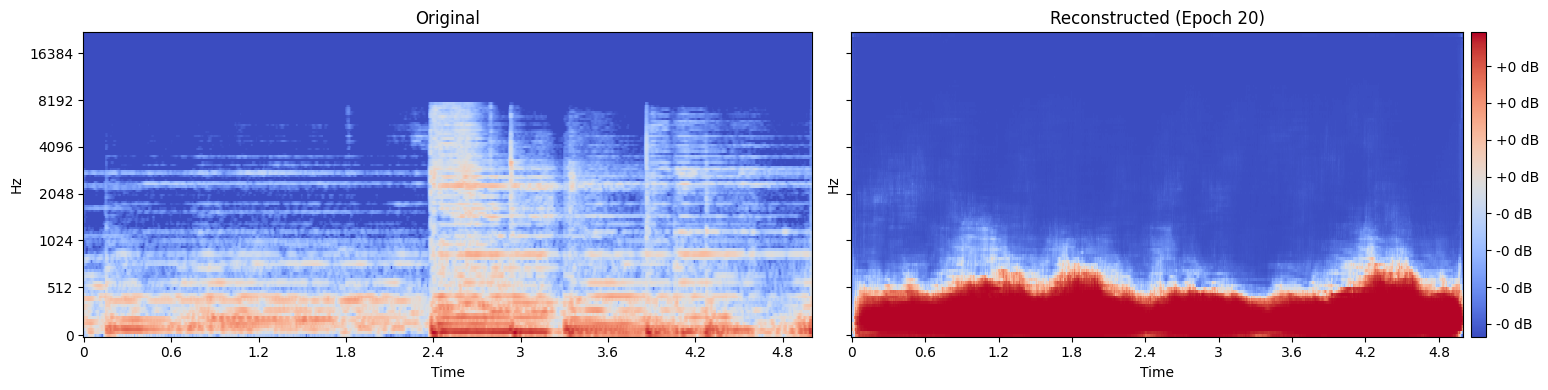

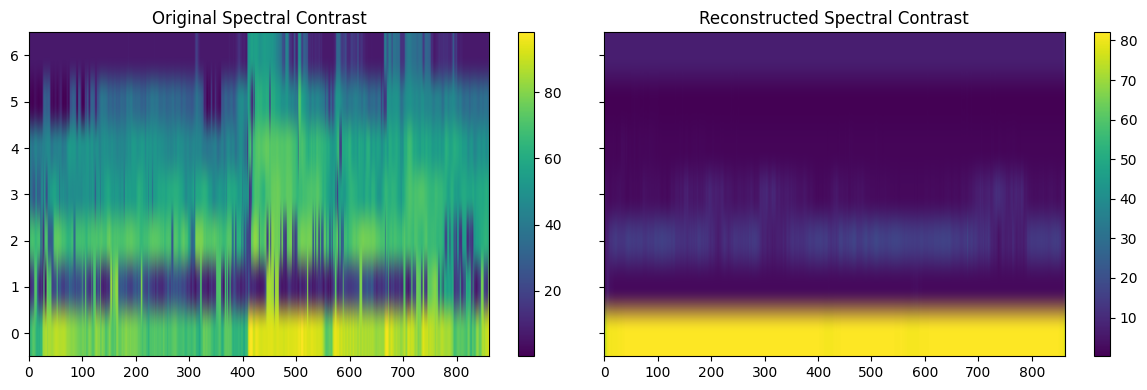

Epoch 21 | Loss=22.8242 | Recon=0.6045 | KL=5.1464 | z.std=1.0000 | Beta=0.100 | Smooth=0.0908 | MS=1.2714 | Contrast=53.8059
Epoch 22 | Loss=22.6055 | Recon=0.6019 | KL=5.1406 | z.std=1.0000 | Beta=0.100 | Smooth=0.0907 | MS=1.2647 | Contrast=53.2690
Epoch 23 | Loss=22.8178 | Recon=0.6019 | KL=5.1391 | z.std=1.0001 | Beta=0.100 | Smooth=0.0905 | MS=1.2656 | Contrast=53.8003
Epoch 24 | Loss=22.4935 | Recon=0.5998 | KL=5.1372 | z.std=1.0000 | Beta=0.100 | Smooth=0.0903 | MS=1.2599 | Contrast=52.9968
Epoch 25 | Loss=22.5171 | Recon=0.5990 | KL=5.1385 | z.std=1.0000 | Beta=0.100 | Smooth=0.0904 | MS=1.2586 | Contrast=53.0577
Original: (128, 862), Recon: (128, 862)


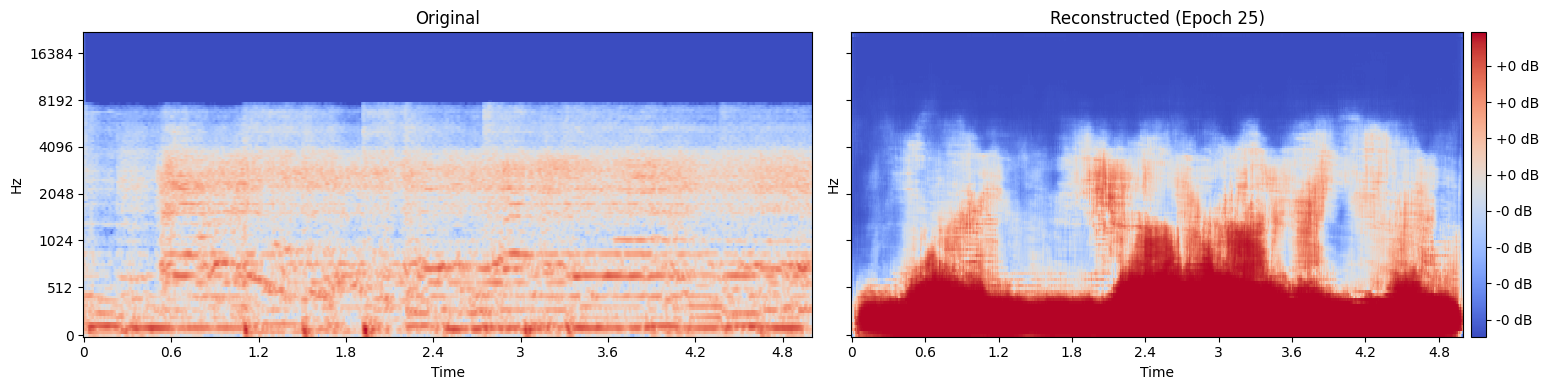

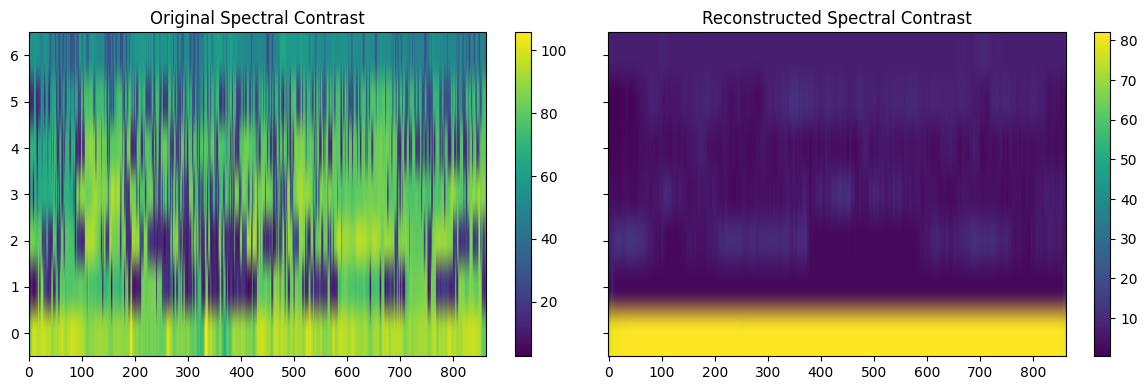

Epoch 26 | Loss=22.5826 | Recon=0.5973 | KL=5.1366 | z.std=1.0001 | Beta=0.100 | Smooth=0.0900 | MS=1.2546 | Contrast=53.2277
Epoch 27 | Loss=22.5023 | Recon=0.5965 | KL=5.1349 | z.std=1.0000 | Beta=0.100 | Smooth=0.0901 | MS=1.2531 | Contrast=53.0296
Epoch 28 | Loss=22.3174 | Recon=0.5935 | KL=5.1338 | z.std=1.0000 | Beta=0.100 | Smooth=0.0900 | MS=1.2458 | Contrast=52.5772
Epoch 29 | Loss=22.2914 | Recon=0.5922 | KL=5.1336 | z.std=0.9999 | Beta=0.100 | Smooth=0.0898 | MS=1.2425 | Contrast=52.5166
Epoch 30 | Loss=22.3817 | Recon=0.5921 | KL=5.1383 | z.std=1.0000 | Beta=0.100 | Smooth=0.0898 | MS=1.2431 | Contrast=52.7413
Original: (128, 862), Recon: (128, 862)


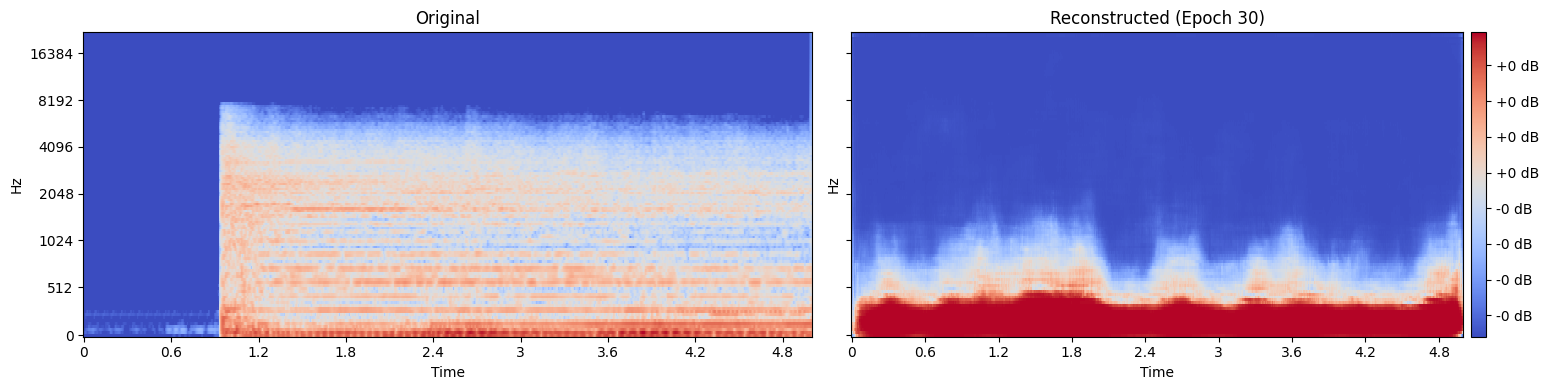

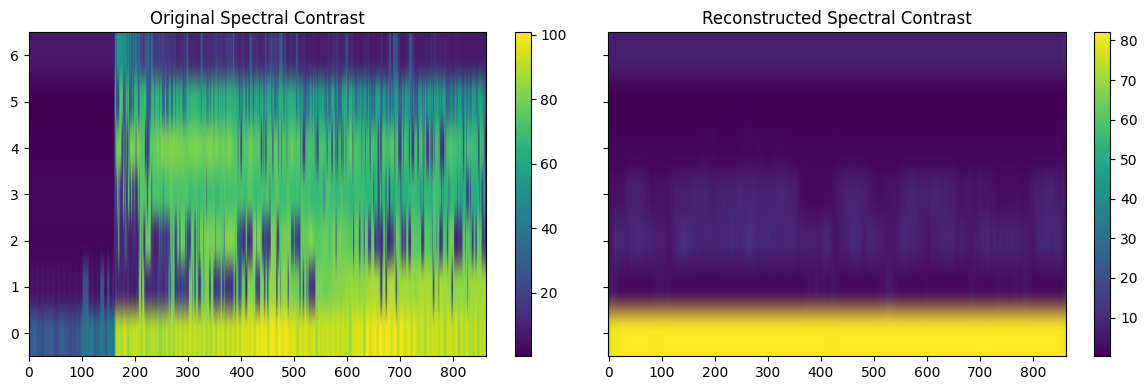

KeyboardInterrupt: 

In [7]:
# === Get Actual Input Size from Dataset ===
sample_batch = next(iter(train_loader))  # returns a Tensor: [B, 1, mel_bins, T]
mel_tensor = sample_batch  # not a dict anymore
mel_dim, time_dim = mel_tensor.shape[-2], mel_tensor.shape[-1]
print(f"Input mel shape: {mel_dim} x {time_dim}")

# === Create VAE Model with Correct Input Shape ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

torch.cuda.empty_cache()
model = VAE(input_dim=(mel_dim, time_dim), latent_dim=512).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)

# === Training Loop ===
num_epochs = 70
initial_lambda_smooth = 0.5
lambda_smooth_min = 0.05  # don't decay all the way to zero

z_std_history = []

lambda_multiscale = 0.1  # added hyperparameter

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0
    total_smooth = 0
    total_ms = 0
    total_contrast = 0  # NEW

    # === KL beta schedule
    if epoch < 10:
        beta = 0.001
    elif epoch < 20:
        beta = 0.05
    elif epoch < 30:
        beta = 0.2
    else:
        beta = min(1.0, 1 / (1 + np.exp(-0.1 * (epoch - 30))))


    # === Smoothing decay schedule
    if epoch < 30:
        lambda_smooth = initial_lambda_smooth
    else:
        lambda_smooth = max(lambda_smooth_min, initial_lambda_smooth * np.exp(-0.03 * (epoch - 30)))

    z_std_epoch = []

    for batch in train_loader:
        x_batch = batch.to(device)

        x_recon, mu, logvar = model(x_batch)
        loss, recon, kl, smooth, ms, contrast = vae_loss(
            x_recon, x_batch, mu, logvar,
            model=model,  # <-- must be passed in
            beta=beta,
            free_bits=0.01,
            lambda_smooth=lambda_smooth,
            lambda_multiscale=lambda_multiscale,
            lambda_contrast=0.6
        )


        if torch.isnan(loss) or torch.isinf(loss) or loss.item() == 0:
            print("⚠️ Skipping NaN or zero loss batch")
            continue

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()
        total_smooth += smooth.item()
        total_ms += ms.item()
        total_contrast += contrast.item()  # NEW

        with torch.no_grad():
            std = torch.exp(0.5 * logvar)
            z = mu + std * torch.randn_like(std)
            z = z / z.std(dim=1, keepdim=True).clamp(min=1e-6)  # ✅ normalize latent
            z_std_epoch.append(z.std().item())

            if z.std().item() < 0.01:
                print(f"⚠️ Warning: z.std too small at epoch {epoch+1}: {z.std().item():.5f}")


    # === Logging per epoch
    avg_z_std = np.mean(z_std_epoch)
    z_std_history.append(avg_z_std)

    avg_loss = total_loss / len(train_loader)
    avg_recon = total_recon / len(train_loader)
    avg_kl = total_kl / len(train_loader)
    avg_smooth = total_smooth / len(train_loader)
    avg_ms = total_ms / len(train_loader)
    avg_contrast = total_contrast / len(train_loader)  # NEW

    print(f"Epoch {epoch+1:02d} | Loss={avg_loss:.4f} | Recon={avg_recon:.4f} | KL={avg_kl:.4f} | "
      f"z.std={avg_z_std:.4f} | Beta={beta:.3f} | Smooth={avg_smooth:.4f} | MS={avg_ms:.4f} | "
      f"Contrast={avg_contrast:.4f}")


    torch.cuda.empty_cache()

    # === Visualization
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            batch = next(iter(train_loader))
            x_val = batch.to(device) if isinstance(batch, torch.Tensor) else batch['mel'].to(device)

            x_recon, _, _ = model(x_val)

            mel_orig = x_val[0].squeeze().cpu().numpy()        # shape: [128, T]
            mel_recon = x_recon[0].squeeze().cpu().numpy()     # shape: [128, T]
            print(f"Original: {mel_orig.shape}, Recon: {mel_recon.shape}")

            # === Plot mel spectrograms
            fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)
            img1 = librosa.display.specshow(mel_orig, sr=44100, hop_length=256, ax=axs[0], x_axis='time', y_axis='mel')
            axs[0].set_title("Original")

            img2 = librosa.display.specshow(mel_recon, sr=44100, hop_length=256, ax=axs[1], x_axis='time', y_axis='mel')
            axs[1].set_title(f"Reconstructed (Epoch {epoch+1})")

            fig.colorbar(img2, ax=axs[1], format="%+2.0f dB", orientation='vertical', pad=0.01)
            plt.tight_layout()
            plt.show()

            # === Plot contrast maps (normalized → linear power → linear freq)
            plot_contrast_maps(mel_orig, mel_recon)  # pass normalized [-1, 1] arrays directly


🎲 Sampling 5 clips from prior N(0,1)


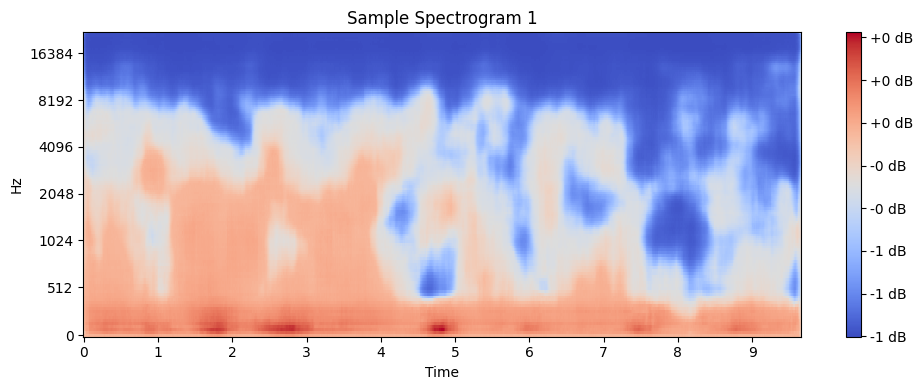

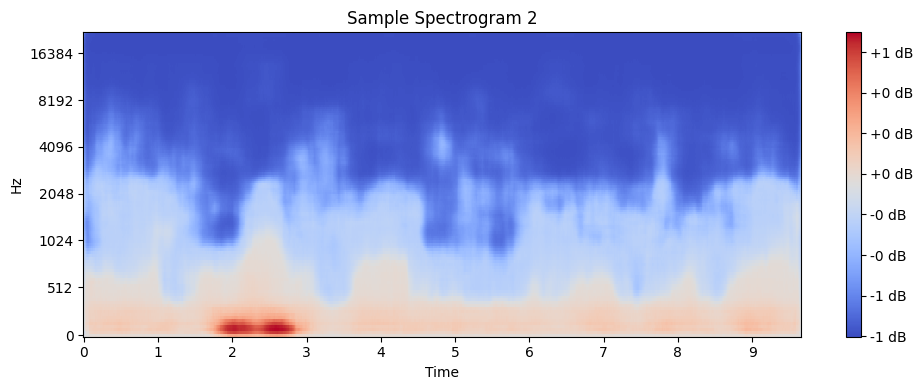

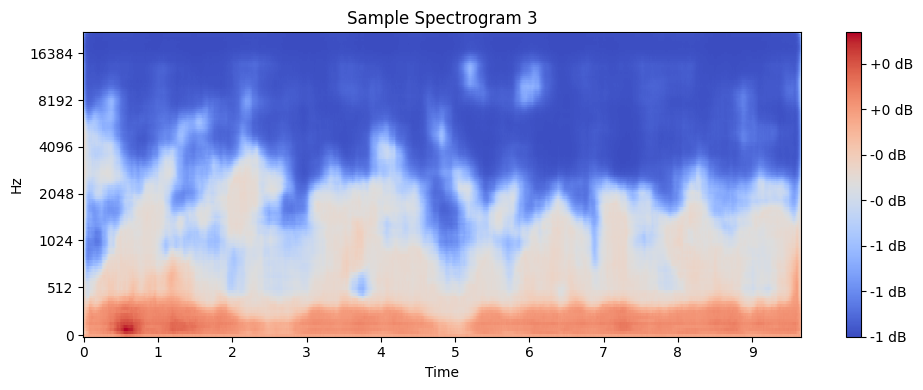

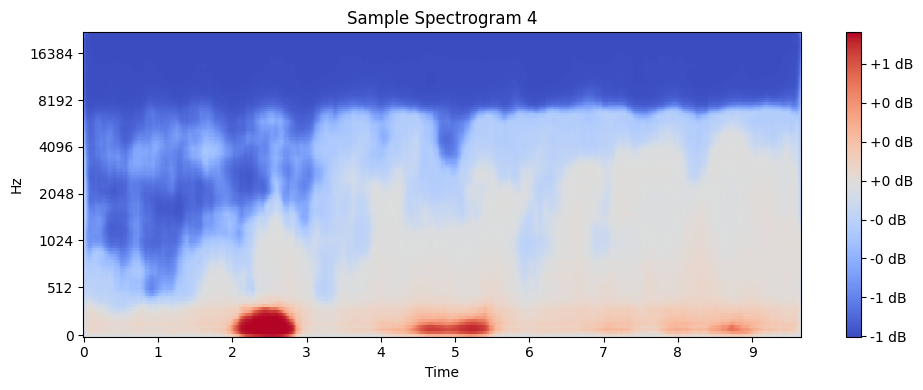

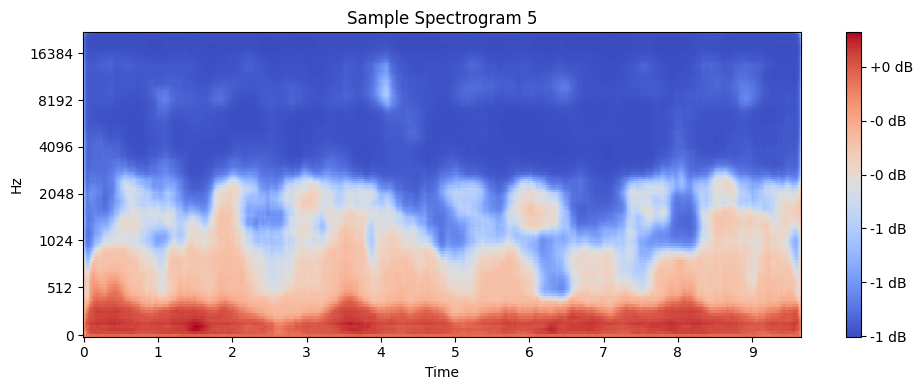

✅ Exported continuous_unconditioned.mp3 — duration: 48.2 seconds


In [ ]:
def plot_mel_output(mel, sr=44100, title="Mel Output"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel, sr=sr, hop_length=256, y_axis='mel', x_axis='time')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def generate_audio_sample(
    model,
    train_loader,
    sr=44100,
    n_samples=5,  # default clip count
    sample_mode="recon",  # or "random"
    plot=True,
    device=None
):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    hop_length = 512
    os.makedirs("temp_clips", exist_ok=True)
    audio_clips = []

    # === Get latent vectors
    with torch.no_grad():
        batch = next(iter(train_loader)).to(device)
        mu, logvar = model.encode(batch)

        if sample_mode == "random":
            z_all = torch.randn_like(mu)
            print(f"🎲 Sampling {n_samples} clips from prior N(0,1)")
        else:
            z_all = model.reparameterize(mu, logvar)
            print(f"🎵 Reconstructing {n_samples} clips from real data")

    n_samples = min(n_samples, z_all.size(0))

    for i in range(n_samples):
        z = z_all[i].unsqueeze(0)

        with torch.no_grad():
            mel_out = model.decode(z).cpu().squeeze().numpy()

        # === Plot (optional)
        if plot:
            plot_mel_output(mel_out, sr=sr, title=f"Sample Spectrogram {i+1}")

        # === Rescale: [-1, 1] → [-80, 0] dB
        mel_out = np.clip(mel_out, -1.0, 1.0)
        mel_db = mel_out * 40.0  # [-1, 1] → [-40, 40]
        mel_db = np.clip(mel_db, -80.0, 0.0)

        # === dB to linear power
        mel_power = librosa.db_to_power(mel_db)

        # === Griffin-Lim to waveform
        audio = librosa.feature.inverse.mel_to_audio(
            mel_power,
            sr=sr,
            n_fft=1024,
            hop_length=hop_length,
            win_length=1024,
            n_iter=60,
            fmax=8000  # ← this fixes the empty filter warning
        )


        # === Save clip
        temp_path = f"temp_clips/clip_{i}.wav"
        sf.write(temp_path, audio, sr)
        audio_clips.append(AudioSegment.from_wav(temp_path))

    # === Combine clips and export final audio
    final_audio = sum(audio_clips)
    final_audio.export("continuous_unconditioned.mp3", format="mp3")
    print(f"✅ Exported continuous_unconditioned.mp3 — duration: {final_audio.duration_seconds:.1f} seconds")


generate_audio_sample(model, train_loader, n_samples=5, sample_mode="recon")

